In [75]:
# Problem 1:Some income data, lognormal distribution, and hypothesis testing

import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
from matplotlib.ticker import MultipleLocator

%matplotlib notebook
income = np.loadtxt('incomes.txt', delimiter = ',', unpack = True)

<IPython.core.display.Javascript object>


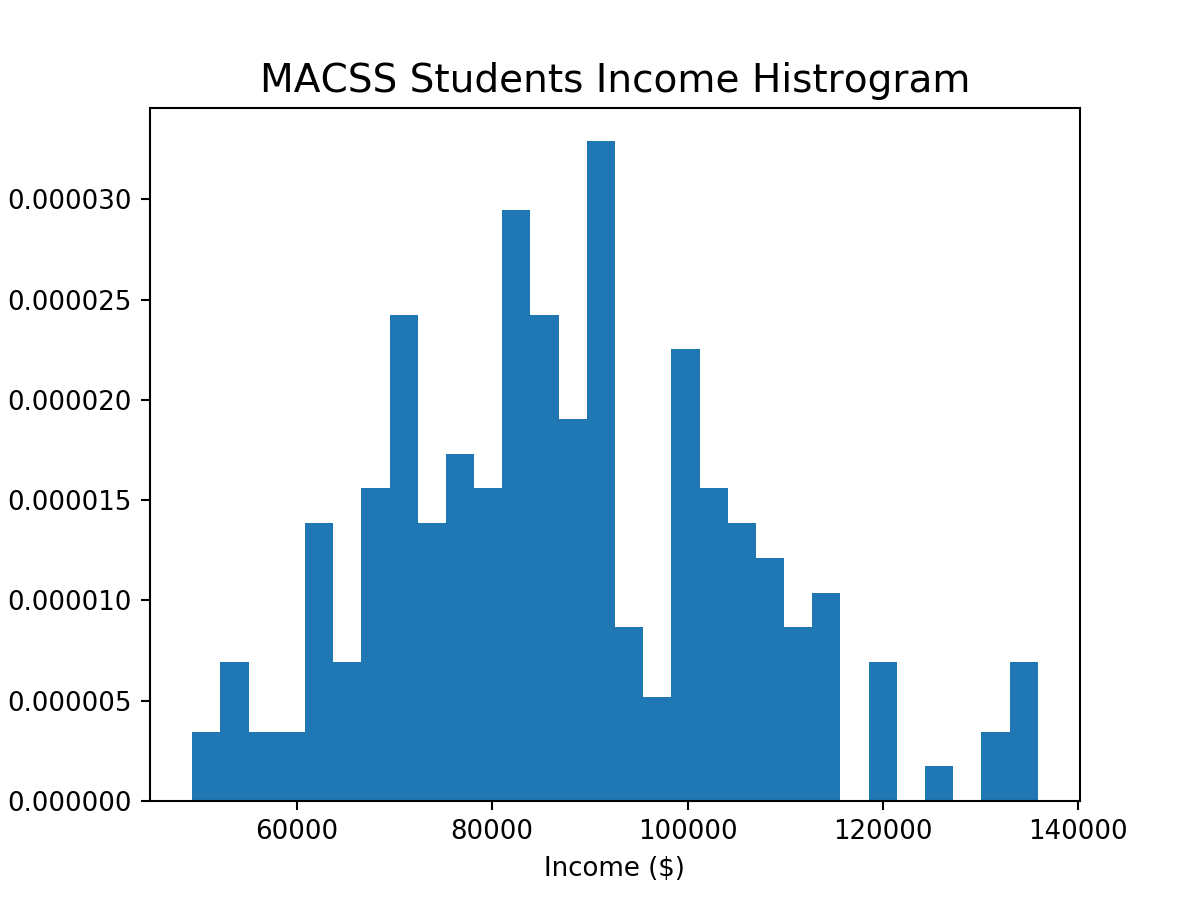

In [76]:
# (a)
plt.hist(income, 30, normed = True)
plt.title('MACSS Students Income Histrogram', fontsize = 15)
plt.xlabel('Income ($)')
plt.ylabel('Percent of observations')
plt.savefig('histogram.png')

In [77]:
# (b)
def calculate_lognorm_pdf(xvals, mu, sigma):
    pdf_vals = sts.lognorm.pdf(xvals, sigma, loc = 0, scale = np.exp(mu))
    return pdf_vals

<IPython.core.display.Javascript object>


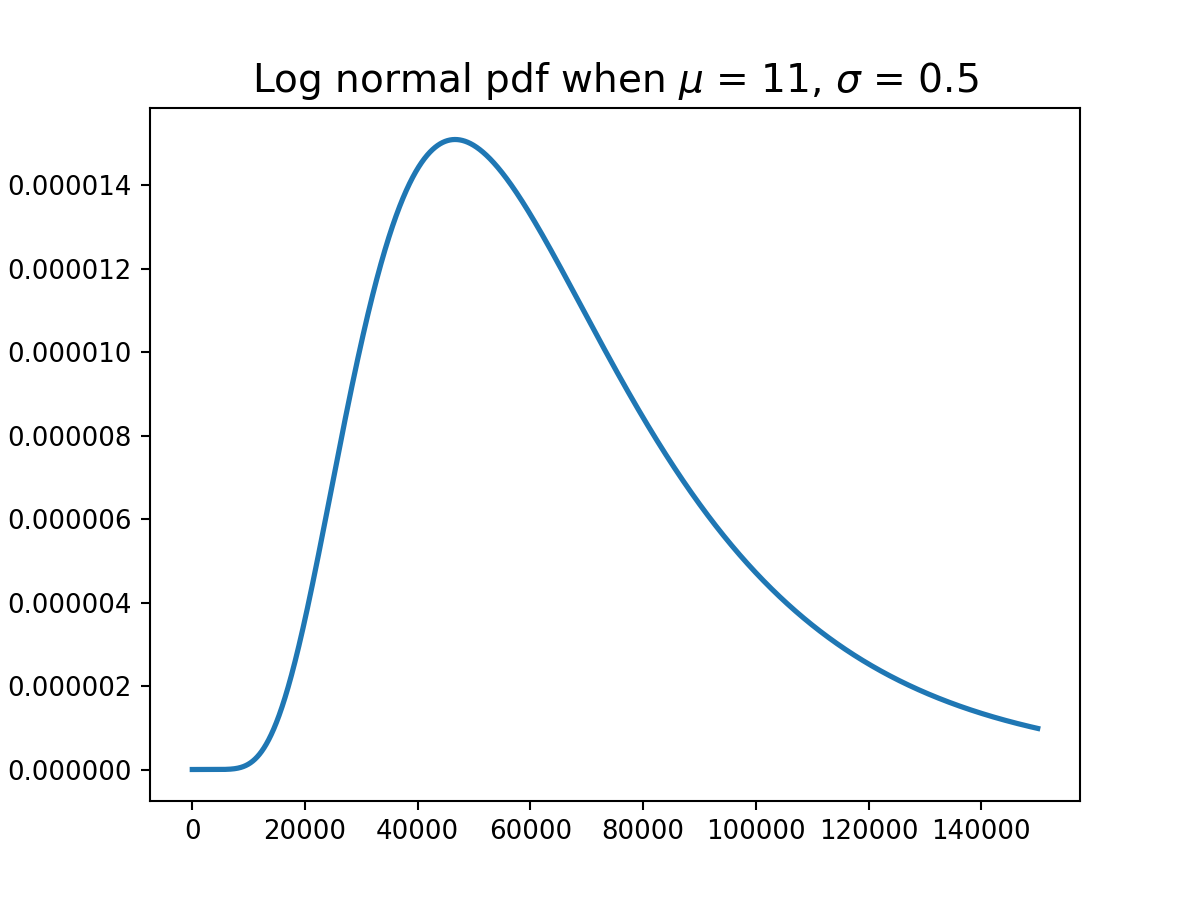

In [78]:
mu = 11
sigma = 0.5
xvals = np.linspace(1e-10, 150000, 15000)

plt.plot(xvals, calculate_lognorm_pdf(xvals, mu, sigma), linewidth = 2)
plt.title('Log normal pdf when $\mu$ = 11, $\sigma$ = 0.5', fontsize = 15)
plt.savefig('lognormal.png')

In [79]:
def log_lik_log_normal(xvals, mu, sigma):
    pdf_vals = calculate_lognorm_pdf(xvals, mu, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood for this parameterization of the distribution given this data:', 
       log_lik_log_normal(income, mu, sigma))

Log-likelihood for this parameterization of the distribution given this data: -2385.856997808558


In [81]:
# (c)
def crit(params, *args):
    mu, sigma = params
    xvals = args
    log_lik_val = log_lik_log_normal(xvals, mu, sigma)
    
    return -log_lik_val

In [82]:
mu_init = 11
sigma_init = 0.5

params_init = np.array([mu_init, sigma_init])
mle_args = (income)
results = opt.minimize(crit, params_init, args = (mle_args), method = 'L-BFGS-B', 
                       bounds = ((0.1, None), (0.1, None)))
mu_MLE, sigma_MLE = results.x

OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv * OffDiagNeg

print('mu_MLE =', mu_MLE, ' sigma_MLE = ', sigma_MLE)
print('Value for likelihood function:', log_lik_log_normal(income, mu_MLE, sigma_MLE))
print('VCV(MLE) = ', vcv_mle)

mu_MLE = 11.359024408524032  sigma_MLE =  0.20817853372391718
Value for likelihood function: -2241.7193013686356
VCV(MLE) =  [[ 0.00022522 -0.00022522]
 [-0.00010283  0.00010283]]


<IPython.core.display.Javascript object>


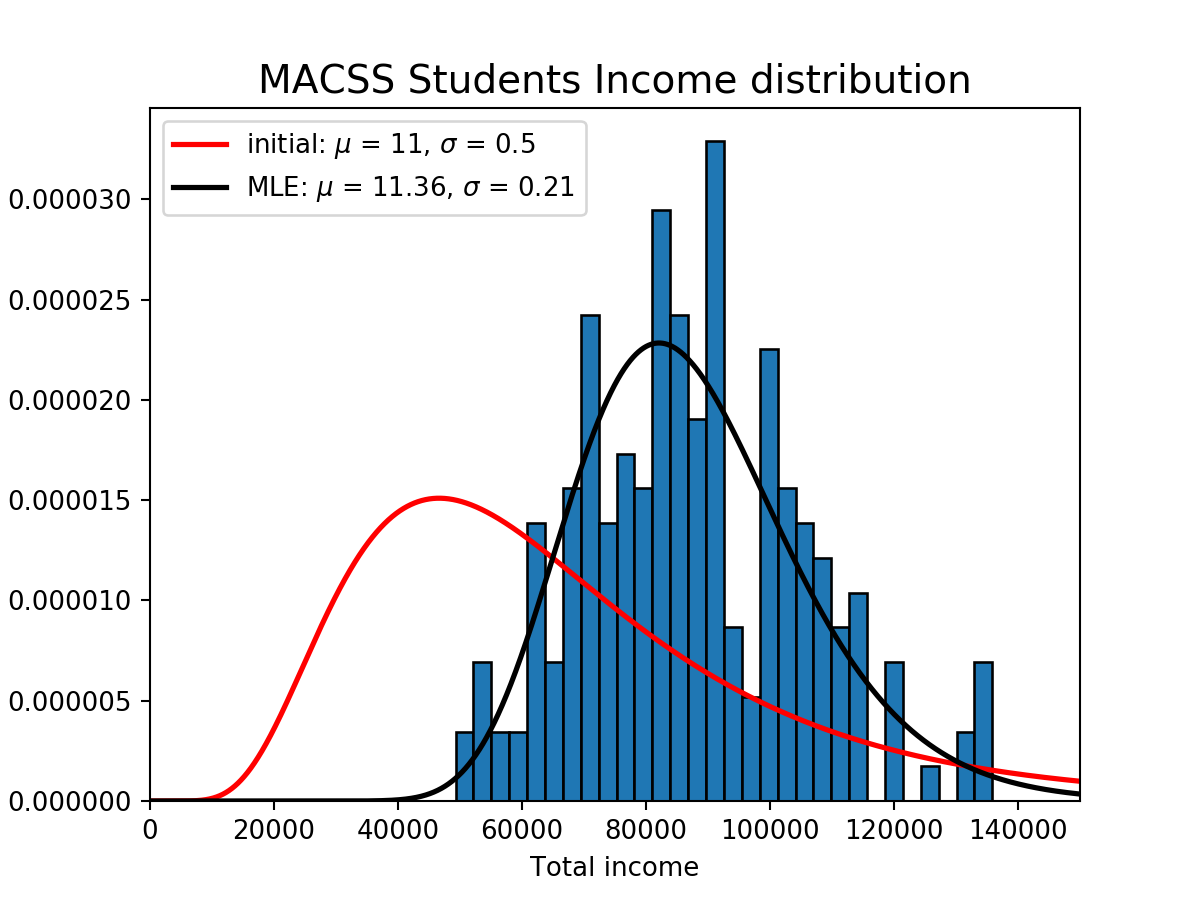

In [83]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor = 'black', normed = True)
plt.title('MACSS Students Income distribution', fontsize = 15)
plt.xlabel('Total income')
plt.ylabel('Percent of income')
plt.xlim([0, 150000])

# Plot the initial distribution
plt.plot(xvals, calculate_lognorm_pdf(xvals, mu, sigma),
         linewidth = 2, color = 'r', label = 'initial: $\mu$ = 11, $\sigma$ = 0.5')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(xvals, calculate_lognorm_pdf(xvals, mu_MLE, sigma_MLE),
         linewidth = 2, color = 'k', label = 'MLE: $\mu$ = 11.36, $\sigma$ = 0.21')
plt.legend(loc = 'upper left')
plt.savefig('MLEplots.png')

In [84]:
log_lik_h0 = log_lik_log_normal(income, mu, sigma)
log_lik_mle = log_lik_log_normal(income, mu_MLE, sigma_MLE)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)

print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)
print('The probability that the data in incomes.txt came from the distribution in part (b) is', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0
The probability that the data in incomes.txt came from the distribution in part (b) is 0.0


In [87]:
high_income_prob = 1 - sts.lognorm.cdf(100000, sigma_MLE, loc = 0, scale = np.exp(mu_MLE))
low_income_prob = sts.lognorm.cdf(75000, sigma_MLE, loc = 0, scale = np.exp(mu_MLE))

print('The probability that I will earn more than $100,000 is : ', high_income_prob)
print('The probability that I will earn less than $75,000 is : ', low_income_prob)

The probability that I will earn more than $100,000 is :  0.2298702015953249
The probability that I will earn less than $75,000 is :  0.26023328312006


In [88]:
# Problem 2: Linear regression and MLE
# (a)
data = pd.read_csv('sick.txt') 
variables = (data['sick'], data['age'], data['children'], data['avgtemp_winter'])
n = len(data)

In [89]:
def total_error(params, variables):
    b0, b1, b2, b3, sigma = params
    sick, age, children, winter = variables
    error = (sick - b0 - b1 * age - b2 * children - b3 * winter) ** 2
    return error.sum()

def log_lik_val(params, variables, n):
    error = total_error(params, variables)
    b0, b1, b2, b3, sigma = params
    log_lik = - (n * np.log (2 * np.pi)) / 2  - (n * np.log(sigma ** 2)) / 2 - (1 / (2 * sigma ** 2)) * error
    
    return log_lik

def crit(params, *variables):
    b0, b1, b2, b3, sigma = params
    sick, age, children, winter = variables
    log_lik = log_lik_val(params, variables, n)
    
    return -log_lik

In [90]:
b0_init, b1_init, b2_init, b3_init, sigma_init = (0.5, 0.5, 0.5, 0.5, 0.5)
params_init = np.array([b0_init, b1_init, b2_init, b3_init, sigma_init])
mle_args = (variables)

results = opt.minimize(crit, params_init, args = (mle_args), method = 'L-BFGS-B',
                       bounds=((None, None), (None, None),(None, None), (None, None),(1e-10, None)))

b0_MLE, b1_MLE, b2_MLE, b3_MLE, sigma_MLE = results.x
OffDiagNeg = np.eye(5)*2 - 1
vcv_mle = results.hess_inv * OffDiagNeg

In [91]:
print('Estimates for b0, b1, b2, b3 and sigma**2 are : ', b0_MLE, b1_MLE, b2_MLE, b3_MLE, sigma_MLE ** 2)
print('The log likelihood function value is :', log_lik_val(results.x, variables, n))
print('The estimated variance covariance matrix is:', vcv_mle)

Estimates for b0, b1, b2, b3 and sigma**2 are :  0.2516440324896288 0.01293331402914296 0.4005021680957474 -0.009991593056292844 9.106898987980589e-06
The log likelihood function value is : 876.865057060357
The estimated variance covariance matrix is: [[ 1935.96771611  -202.52135804 -1992.25336693  -604.24350259
   -374.21499224]
 [  173.26762751   -17.80872025  -178.20278304   -53.81945902
    -33.33521223]
 [-1303.70666974   134.5549286   1341.02023048   405.40802301
    251.09807553]
 [ -158.28509396    16.34996406   162.81973446    49.23225365
     30.49286401]
 [   31.06999233    -3.83921321   -32.16363709   -10.18056006
     -6.29713196]]


In [92]:
# (b)
params_h0 = (1, 0, 0, 0, 0.01)
log_lik_h0 = log_lik_val(params_h0, variables, n)
log_lik_mle = log_lik_val(results.x, variables, n)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)

print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)
print('The likelihood that age, the number of children, and average winter temperature have no effct on\
       the number of sick days is',  pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0
The likelihood that age, the number of children, and average winter temperature have no effct on       the number of sick days is 0.0
